In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [19]:
import pyhf
reload(pyhf)
import logging
logging.basicConfig(level = logging.INFO)
from pyhf import hfpdf
def prep_data(sourcedata):
    spec =  {
        'signal': {
            'signal': {
                'data': sourcedata['signal']['bindata']['sig'],
                'mods': [
                    {
                        'name': 'mu',
                        'type': 'normfactor',
                        'data': None
                    }
                ]
            },
            'bkg1': {
                'data': sourcedata['signal']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_histosys',
                        'type': 'histosys',
                        'data':  {'lo_hist': sourcedata['signal']['bindata']['bkg1_dn'], 'hi_hist': sourcedata['signal']['bindata']['bkg1_up']}
                    }
                ]
            },
            'bkg2': {
                'data': sourcedata['signal']['bindata']['bkg2'],
                'mods': [
                    {
                        'name': 'coupled_histosys',
                        'type': 'histosys',
                        'data':  {'lo_hist': sourcedata['signal']['bindata']['bkg2_dn'], 'hi_hist': sourcedata['signal']['bindata']['bkg2_up']}
                    }
                ]
            }
        },
        'control': {
            'background': {
                'data': sourcedata['control']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_histosys',
                        'type': 'histosys',
                        'data':  {'lo_hist': sourcedata['control']['bindata']['bkg1_dn'], 'hi_hist': sourcedata['control']['bindata']['bkg1_up']}
                    }
                ]
            }
        }
    }
    pdf  = hfpdf(spec)
    data = []
    for c in pdf.channel_order:
        data += sourcedata[c]['bindata']['data']
    data = data + pdf.auxdata
    return data, pdf

In [20]:
import json
source = json.load(open('../../validation/data/2bin_2channel_coupledhisto.json'))


d,pdf = prep_data(source['channels'])

print (d)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.unconstrained_bestfit(d,pdf,init_pars,par_bounds)
print ('UNCON',unconpars)

conpars = pyhf.constrained_bestfit(0.0,d,pdf,init_pars,par_bounds)
print ('CONS', conpars)

pdf.expected_data(conpars)

INFO:pyhf:adding modifier coupled_histosys (1 new nuisance parameters)
INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:accepting existing histosys
INFO:pyhf:accepting existing histosys


[110.0, 105.0, 170.0, 220.0, 0, 0, 0]
('UNCON', array([0.27003651, 0.46194741]))
('CONS', array([0.14179813, 0.        ]))


/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:16: RuntimeWarning: invalid value encountered in sqrt
  return norm.pdf(n, loc = lam, scale = np.sqrt(lam))
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1653: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/Users/lukas/Code/histfactory/pyhf/venv/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1654: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)


array([1.05708991e+02, 1.02126972e+02, 1.52126972e+02, 2.12201103e+02,
       1.41798128e-01, 1.41798128e-01, 1.41798128e-01])

/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:366: RuntimeWarning: divide by zero encountered in double_scalars
  CLs  = CLb/CLsb


{'exp': [0.3277345829513242,
  0.4537751313932091,
  0.6434662886946377,
  0.9180887336497598,
  1.2744715070186352],
 'obs': 1.0478812654904552}

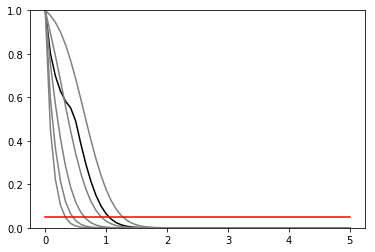

In [21]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest,d,pdf, init_pars,par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, d,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross


CLsOnePoint(1.0,d,pdf,init_pars,par_bounds)


mutests = np.linspace(0,5,61)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)




In [22]:
CLsOnePoint(1.0,d,pdf,init_pars,par_bounds)


(0.06406791030101676,
 [1.6538409169005294e-05,
  0.0002490863040337432,
  0.0032056269173357244,
  0.03060508439328246,
  0.17574126217230668])